# HW 4
For this homework, we will be applying volatility models (i.e. ARCH and GARCH) on the data that we used in the previous homework.

In [1]:
# Numerical/Statistical Libraries
import pandas as pd
from scipy.stats import skew, kurtosis, jarque_bera
import numpy as np
import statsmodels.api as sm 
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import het_arch

# Plotting Libraries
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Various Utilities
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_excel(r"C:\Users\Jared\OneDrive\Mines\FALL2024\EBGN594\MISO_PJM_data\raw_data.xlsx")

df = pd.DataFrame({
    'Date/Time': data['Date/Time'],
    'MISO FC ERROR (MW)': data['MISO FORECAST ERROR'],
    'Temperature (F)': data['temperature'],
    'Snowfall (inch)': data['snowfall (inch)'],
    'Wind Speed (mph)': data['wind_speed_100m (mp/h)']
})

df.set_index('Date/Time', inplace=True)


In [4]:
adf_results = []

# Perform ADF test for each series (excluding the Date/Time column)
for column in df.columns:  
    series = df[column].dropna()  
    adf_test = adf(series, maxlag=30, autolag='BIC')
    adf_results.append({
        'Variable': column,
        'ADF Statistic': adf_test[0],
        'p-value': adf_test[1],
        'Lags Used': adf_test[2],
        'Number of Observations Used': adf_test[3],
        'Critical Values': adf_test[4]
    })

# Convert results to a DataFrame for display
adf_results_df = pd.DataFrame(adf_results)

display(adf_results_df)

,Variable,ADF Statistic,p-value,Lags Used,Number of Observations Used,Critical Values
0,MISO FC ERROR (MW),-32.766147,0.000000e+00,26,43845,"{'1%': -3.430499154587524, '5%': -2.8616059230..."
1,Temperature (F),-8.306195,3.897860e-13,30,43841,"{'1%': -3.4304991681970054, '5%': -2.861605929..."
2,Snowfall (inch),-32.833404,0.000000e+00,25,43846,"{'1%': -3.4304991511855416, '5%': -2.861605921..."
3,Wind Speed (mph),-30.610417,0.000000e+00,25,43846,"{'1%': -3.4304991511855416, '5%': -2.861605921..."


First, let's seasonally adjust each data series to ensure stationarity and to remove any seasonal components of the data.

In [5]:
# Perform seasonal adjustment for each variable
seasonally_adjusted = {}

for column in df.columns[1:]:
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(df[column], model='additive', period=24)  # Weekly seasonality assumed (hourly data)
    
    # Subtract the seasonal component to get seasonally adjusted data
    seasonally_adjusted[column] = df[column] - decomposition.seasonal

# Combine adjusted variables into a new DataFrame
adjusted_df = pd.DataFrame(seasonally_adjusted)

# Set negative values to zero for snowfall and wind speed
adjusted_df['Snowfall (inch)'] = adjusted_df['Snowfall (inch)'].clip(lower=0)
adjusted_df['Wind Speed (mph)'] = adjusted_df['Wind Speed (mph)'].clip(lower=0)

df['Temperature (F)'] = adjusted_df['Temperature (F)']
df['Snowfall (inch)'] = adjusted_df['Snowfall (inch)']
df['Wind Speed (mph)'] = adjusted_df['Wind Speed (mph)']

## 1. 

### Testing for auto correlation
We will be testing the residuals and squared residuals for autocorrelation first. We perform a Ljung-Box test up to lags 10, 20, and 30. All have negligible p-values, presenting strong evidence of serial autocorrelation in the residuals.

In [6]:
y = df['MISO FC ERROR (MW)']

# Calculate residuals and squared residuals
residuals = y 
squared_residuals = residuals ** 2

# Test for autocorrelation in residuals
ljung_box_residuals = acorr_ljungbox(residuals, lags=30, return_df=True)

# Test for autocorrelation in squared residuals
ljung_box_squared_residuals = acorr_ljungbox(squared_residuals, lags=30, return_df=True)

# Combine results into a single DataFrame for clarity
autocorrelation_results = pd.DataFrame({
    "Residuals P-Value": ljung_box_residuals['lb_pvalue'],
    "Squared Residuals P-Value": ljung_box_squared_residuals['lb_pvalue']
})

trimmed_autocorrelation_results = autocorrelation_results.iloc[[9, 19, 29]]

display(trimmed_autocorrelation_results)


,Residuals P-Value,Squared Residuals P-Value
10,0.0,5.352123e-09
20,0.0,5.253973e-07
30,0.0,4.243357e-05


### Estimating models
Next, we will be estimating a few volatility models by fitting them to the residuals, namely an ARCH, GARCH, and ARMA-GARCH model. First, we define a baseline ARIMA(1,1,1) that was selected based off of the BIC. Then, we fit the ARCH and GARCH models to the ARIMA residuals.

In [7]:
# ARIMA(1,1,1)
arima_model = ARIMA(y, order=(1,1,1)).fit()
residuals = arima_model.resid

**ARCH(1)**

In [8]:
arch = arch_model(residuals,vol='ARCH',p=1)
arch_results = arch.fit(disp='off')
print(arch_results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -344082.
Distribution:                  Normal   AIC:                           688171.
Method:            Maximum Likelihood   BIC:                           688197.
                                        No. Observations:                43872
Date:                Thu, Nov 21 2024   Df Residuals:                    43871
Time:                        13:18:52   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -5.7615     13.512     -0.426      0.670 [-32.245, 20.72

**GARCH(1,1)**

In [9]:
garch = arch_model(residuals,vol='GARCH',p=1,q=1)
garch_results = garch.fit(disp='off')
print(garch_results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -341150.
Distribution:                  Normal   AIC:                           682309.
Method:            Maximum Likelihood   BIC:                           682344.
                                        No. Observations:                43872
Date:                Thu, Nov 21 2024   Df Residuals:                    43871
Time:                        13:18:52   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -1.9601      7.139     -0.275      0.784 [-15.952, 12.03

**NOTE: There is no automated way to simultaneously fit an ARMA-GARCH model in Python, so I outsourced that part to R**

### Analysis of models
Both the ARCH and GARCH models seem to have an incredibly weak fit: most of their coefficients are insignificant, the $R^2$ value is negligible, and the BIC statistics are massive. As for the ARIMA(1,1,1)-GARCH(1,1), the goodness-of-fit is much improved with a much lower BIC statistic and more statistically significant coefficients.Also, when performing the Ljung-Box test at lags 10, 20, and 30, we can see that the p-value of all of the tests for ARCH and GARCH are negligible. The same can also be said for the ARIMA(1,1,1)-GARCH(1,1) model. All of these models seem to present strong evidence of autocorrelation in the residuals.

Below is a chart of the ARIMA-GARCH model's forecasted volatility.

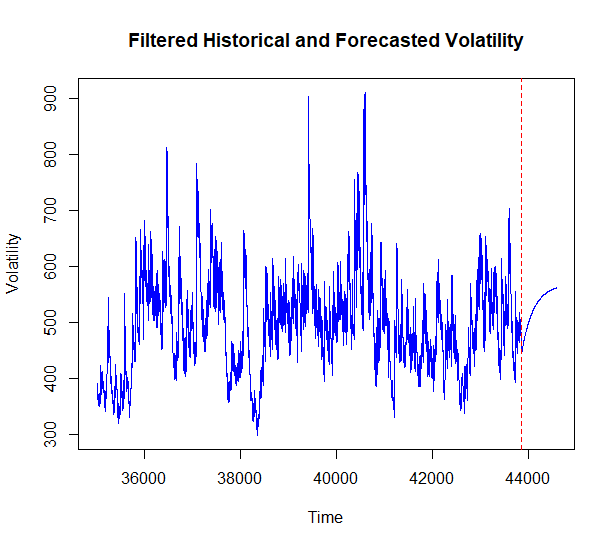

In [10]:
# ARCH and GARCH residuals
arch_resid = arch_results.resid
arch_sq_resid = arch_resid ** 2

garch_resid = garch_results.resid
garch_sq_resid = garch_resid ** 2

# Test for autocorrelation in ARCH residuals
arch_ljung_box_residuals = acorr_ljungbox(arch_resid, lags=30, return_df=True)
arch_ljung_box_squared_residuals = acorr_ljungbox(arch_sq_resid, lags=30, return_df=True)

# Combine results for ARCH
arch_autocorrelation_results = pd.DataFrame({
    "ARCH Residuals P-Value": arch_ljung_box_residuals['lb_pvalue'],
    "ARCH Squared Residuals P-Value": arch_ljung_box_squared_residuals['lb_pvalue']
})

# Trim to lags 10, 20, 30 for ARCH
trimmed_arch_autocorrelation_results = arch_autocorrelation_results.iloc[[9, 19, 29]]

# Test for autocorrelation in GARCH residuals
garch_ljung_box_residuals = acorr_ljungbox(garch_resid, lags=30, return_df=True)
garch_ljung_box_squared_residuals = acorr_ljungbox(garch_sq_resid, lags=30, return_df=True)

# Combine results for GARCH
garch_autocorrelation_results = pd.DataFrame({
    "GARCH Residuals P-Value": garch_ljung_box_residuals['lb_pvalue'],
    "GARCH Squared Residuals P-Value": garch_ljung_box_squared_residuals['lb_pvalue']
})

# Trim to lags 10, 20, 30 for GARCH
trimmed_garch_autocorrelation_results = garch_autocorrelation_results.iloc[[9, 19, 29]]

# Combine ARCH and GARCH results for final display
combined_results = pd.concat([
    trimmed_arch_autocorrelation_results.reset_index(drop=True),
    trimmed_garch_autocorrelation_results.reset_index(drop=True)
], axis=1)

combined_results['ARMA-GARCH Residuals P-value']= [0,0,0]
combined_results['ARMA-GARCH Squared Residuals P-value']= [0,0,0]

display(combined_results)

,ARCH Residuals P-Value,ARCH Squared Residuals P-Value,GARCH Residuals P-Value,GARCH Squared Residuals P-Value,ARMA-GARCH Residuals P-value,ARMA-GARCH Squared Residuals P-value
0,1.170871e-115,0.0,1.170871e-115,0.0,0,0
1,1.874138e-207,0.0,1.874138e-207,0.0,0,0
2,0.000000e+00,0.0,0.000000e+00,0.0,0,0


## 2.
### VAR Estimation
Here we estimate a VAR model and choose the order based off of the BIC. For this model, the algorithm chose the order p=3. The summary is in the truncated output cell.

In [11]:
# VAR Model
model = VAR(df)
order = model.select_order()
lag = order.bic

results = model.fit(lag)

print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Nov, 2024
Time:                     13:19:00
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    7.49046
Nobs:                     43846.0    HQIC:                   7.43346
Log likelihood:          -410828.    FPE:                    1647.86
AIC:                      7.40723    Det(Omega_mle):         1632.17
--------------------------------------------------------------------
Results for equation MISO FC ERROR (MW)
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                        -41.201336        13.794882           -2.987           0.003
L1.MISO FC ERROR (MW)          0.755894         0.004762          158.737           0.000
L1.Temperat

### Testing for ARCH
Here, we extract the residuals from the model and test for ARCH. The table below is the result of Engle's test for ARCH. As we can see, the p-values are unanimously 0, whether they are tested jointly or independently. These p-values indicate a very strong likelihood of ARCH in the residuals for all of the equations.

In [12]:
residuals = results.resid

# Perform ARCH test for each equation's residuals
arch_results = {}
for column in residuals.columns:
    test_stat, p_value, f_stat, f_p = het_arch(residuals[column])
    arch_results[column] = {"Test Statistic": test_stat, "P-Value": p_value, 'F-statistic':f_stat, 'F P-value':f_p}

arch_results_df = pd.DataFrame(arch_results).T
print(arch_results_df)


                    Test Statistic  P-Value  F-statistic  F P-value
MISO FC ERROR (MW)    10201.040163      0.0  1329.154509        0.0
Temperature (F)        3777.751340      0.0   413.298030        0.0
Snowfall (inch)        5076.812104      0.0   574.034964        0.0
Wind Speed (mph)       3552.721331      0.0   386.507796        0.0


## 3.
### Multivariate Volatility Model
First, we extract the standardized residuals from the VAR estimation. After creating the matrix of residuals, we can fit a univariate GARCH(1,1) model to each of the column vectors, which are the standardized residuals of each equation in the VAR model. Then, we repeat the process of applying Engle's test for ARCH to each of the residual series.

As we can see from the test, each of the test statistics and joint statistics heavily improved. For MISO FC ERROR, Temperature, and Snowfall, we fail to reject the null hypothesis that no ARCH effects are present in the residuals, meaning that applying the GARCH model to the standardized residuals of the model seems to have removed a great deal of heteroskedasticity. As for the wind speed variable, the test statistics seem to indicate strong evidence of ARCH effects, even after fitting a GARCH model to the residuals. The GARCH(1,1) model was unable to properly capture the conditional variance dynamics of the wind speed variable equation. Further treatment for this residuals is necessary to capture the dynamics of the residuals.


In [13]:
# Standardize residuals from VAR
standardized_residuals = results.resid / results.resid.std()

# Fit GARCH(1,1) model for each residual series
garch_models = {}
for column in standardized_residuals.columns:
    model = arch_model(standardized_residuals[column], vol='Garch', p=1, q=1, dist='normal')
    garch_models[column] = model.fit(disp='off')

standardized_resid_garch = pd.DataFrame({
    col: garch_models[col].std_resid for col in garch_models.keys()
})

# Testing for ARCH
arch_results_after = {}
for column in standardized_resid_garch.columns:
    test_stat, p_value, f_stat, f_p = het_arch(standardized_resid_garch[column])
    arch_results_after[column] = {"Test Statistic": test_stat, "P-Value": p_value, 'F-Stat':f_stat, 'F P-value':f_p}

arch_results_after_df = pd.DataFrame(arch_results_after).T

# Display results
print(arch_results_after_df)

C:\Users\Jared\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                    Test Statistic   P-Value    F-Stat  F P-value
MISO FC ERROR (MW)        0.037677  1.000000  0.003767   1.000000
Temperature (F)           5.711086  0.838924  0.571040   0.838967
Snowfall (inch)           0.311794  0.999999  0.031172   0.999999
Wind Speed (mph)         37.504001  0.000046  3.752670   0.000046
